In [16]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True)  # SLIPPERY ON

# Slippery needs: MORE episodes, SLOWER decay, HIGHER epsilon_min
num_episodes = 500000  # 2.5x more than deterministic
max_steps = 200
alpha, gamma = 0.1, 0.99
epsilon, epsilon_min, epsilon_decay = 1.0, 0.05, 0.99995  # SLOWER DECAY + higher min


In [17]:
def train_q_learning(alpha, gamma, epsilon, epsilon_min, epsilon_decay, num_episodes, max_steps, env):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    success_rates = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            
            if done or truncated:
                target = reward
            else:
                target = reward + gamma * np.max(Q[next_state])
            
            Q[state, action] += alpha * (target - Q[state, action])
            state = next_state
            
            if done or truncated:
                break
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        success_rates[episode] = 1 if episode_reward > 0 else 0
    
    return Q, success_rates

def train_sarsa(alpha, gamma, epsilon, epsilon_min, epsilon_decay, num_episodes, max_steps, env):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    success_rates = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        # First action
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])
        
        for step in range(max_steps):
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            
            if done or truncated:
                target = reward
            else:
                # Next action using ε-greedy (on-policy)
                if np.random.random() < epsilon:
                    next_action = env.action_space.sample()
                else:
                    next_action = np.argmax(Q[next_state])
                target = reward + gamma * Q[next_state, next_action]
            
            Q[state, action] += alpha * (target - Q[state, action])
            state, action = next_state, next_action
            
            if done or truncated:
                break
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        success_rates[episode] = 1 if episode_reward > 0 else 0
    
    return Q, success_rates

# TRAIN (takes ~10-15 min)
print("Training Q-Learning (Slippery)...")
Q_qlearn, success_qlearn = train_q_learning(0.1, 0.99, 1.0, 0.05, 0.99995, 500000, 200, env)

print("Training SARSA (Slippery)...")
Q_sarsa, success_sarsa = train_sarsa(0.1, 0.99, 1.0, 0.05, 0.99995, 500000, 200, env)


Training Q-Learning (Slippery)...
Training SARSA (Slippery)...


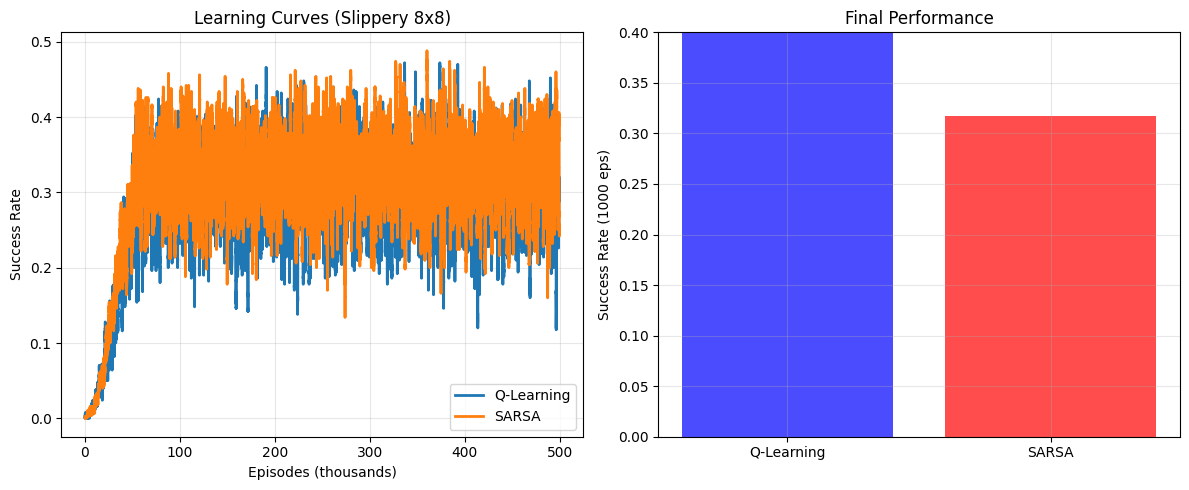

Q-Learning final: 48.2%
SARSA final: 31.7%


In [18]:
def evaluate_policy(Q, env, n_eval=1000):
    success = 0
    for _ in range(n_eval):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done and total_reward > -10:  # Prevent infinite loops
            action = np.argmax(Q[state])
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if truncated: break
        success += (total_reward > 0)
    return success / n_eval

def plot_slippery_comparison(success_qlearn, success_sarsa, window=500):  # Larger window
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    smooth_q = np.convolve(success_qlearn, np.ones(window)/window, mode='valid')
    smooth_s = np.convolve(success_sarsa, np.ones(window)/window, mode='valid')
    episodes = np.arange(window-1, min(len(smooth_q), len(smooth_s)))
    
    plt.plot(episodes/1000, smooth_q[:len(episodes)], label='Q-Learning', linewidth=2)
    plt.plot(episodes/1000, smooth_s[:len(episodes)], label='SARSA', linewidth=2)
    plt.xlabel('Episodes (thousands)'); plt.ylabel('Success Rate')
    plt.title('Learning Curves (Slippery 8x8)'); plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    final_q = evaluate_policy(Q_qlearn, env, 1000)
    final_s = evaluate_policy(Q_sarsa, env, 1000)
    plt.bar(['Q-Learning', 'SARSA'], [final_q, final_s], alpha=0.7, color=['blue', 'red'])
    plt.ylabel('Success Rate (1000 eps)'); plt.title('Final Performance')
    plt.ylim(0, 0.4); plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Q-Learning final: {final_q:.1%}")
    print(f"SARSA final: {final_s:.1%}")

plot_slippery_comparison(success_qlearn, success_sarsa)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# ============================================================================
# EVALUATION & TESTING
# ============================================================================

def evaluate_policy(Q, env, n_eval=1000, render=False):
    """Greedy policy evaluation. Returns success rate."""
    success = 0
    for _ in range(n_eval):
        state, _ = env.reset()
        done = False
        steps = 0
        max_steps = 200
        
        while not done and steps < max_steps:
            action = np.argmax(Q[state])
            state, reward, done, truncated, _ = env.step(action)
            steps += 1
            if truncated:
                break
        
        success += (reward > 0)
    
    return success / n_eval

def quick_test(Q_qlearn, Q_sarsa, env):
    """One-liner test of both policies."""
    q_success = evaluate_policy(Q_qlearn, env, 1000)
    s_success = evaluate_policy(Q_sarsa, env, 1000)
    print(f"Q-Learning: {q_success:.1%} | SARSA: {s_success:.1%}")
    return q_success, s_success

# ============================================================================
# LEARNING CURVE PLOTS
# ============================================================================

def plot_learning_curves(success_qlearn, success_sarsa, window=500, save_path=None):
    """Plot smoothed success rates."""
    smooth_q = np.convolve(success_qlearn, np.ones(window)/window, mode='valid')
    smooth_s = np.convolve(success_sarsa, np.ones(window)/window, mode='valid')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    episodes = np.arange(len(smooth_q))
    
    ax.plot(episodes / 1000, smooth_q, label='Q-Learning (off-policy)', linewidth=2.5, color='#2563eb')
    ax.plot(episodes / 1000, smooth_s, label='SARSA (on-policy)', linewidth=2.5, color='#dc2626')
    ax.set_xlabel('Episodes (thousands)', fontsize=12)
    ax.set_ylabel('Success Rate', fontsize=12)
    ax.set_title('Learning Curves: Q-Learning vs SARSA (8×8 Slippery)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 0.6)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

def plot_hyperparameter_sensitivity(results_dict, param_name, save_path=None):
    """Plot success rate vs hyperparameter values."""
    params = sorted(results_dict.keys())
    successes = [results_dict[p] for p in params]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(params)), successes, alpha=0.7, color='#7c3aed', edgecolor='black')
    ax.set_xticks(range(len(params)))
    ax.set_xticklabels([f"{param_name}={p}" for p in params])
    ax.set_ylabel('Final Success Rate', fontsize=12)
    ax.set_title(f'Sensitivity to {param_name}', fontsize=14, fontweight='bold')
    ax.set_ylim(0, max(successes) * 1.2)
    ax.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(successes):
        ax.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=10, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

def plot_final_comparison(q_success, s_success, save_path=None):
    """Side-by-side bar chart of final success."""
    fig, ax = plt.subplots(figsize=(10, 6))
    algorithms = ['Q-Learning\n(Off-Policy)', 'SARSA\n(On-Policy)']
    successes = [q_success, s_success]
    colors = ['#2563eb', '#dc2626']
    
    bars = ax.bar(algorithms, successes, alpha=0.8, color=colors, edgecolor='black', linewidth=2)
    ax.set_ylabel('Success Rate (1000 eval episodes)', fontsize=12, fontweight='bold')
    ax.set_title('Final Performance: Q-Learning vs SARSA', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 0.6)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, successes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.1%}', ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# ============================================================================
# POLICY VISUALIZATION
# ============================================================================

def visualize_policies_fixed(Q_qlearn, Q_sarsa, env, save_path=None):
    """Fixed policy visualization (handles byte strings correctly)."""
    actions = ['←', '↓', '→', '↑']
    policy_q = np.argmax(Q_qlearn, axis=1).reshape(8, 8)
    policy_s = np.argmax(Q_sarsa, axis=1).reshape(8, 8)
    
    # Get and convert map
    env.reset()
    desc = env.unwrapped.desc
    map_grid = np.array([[char.decode('utf-8') for char in row] for row in desc])
    
    # Numeric map for visualization
    map_numeric = np.zeros((8, 8), dtype=float)
    for i in range(8):
        for j in range(8):
            if map_grid[i,j] == 'S': map_numeric[i,j] = 0
            elif map_grid[i,j] == 'F': map_numeric[i,j] = 1
            elif map_grid[i,j] == 'H': map_numeric[i,j] = 2
            elif map_grid[i,j] == 'G': map_numeric[i,j] = 3
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot backgrounds
    im1 = ax1.imshow(map_numeric, cmap='tab10', vmin=0, vmax=3)
    im2 = ax2.imshow(map_numeric, cmap='tab10', vmin=0, vmax=3)
    
    # Add arrows
    for i in range(8):
        for j in range(8):
            if map_grid[i,j] == 'S':
                continue
            
            ax1.text(j, i, actions[policy_q[i,j]], ha='center', va='center',
                    fontsize=18, fontweight='bold', color='blue',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.85))
            
            ax2.text(j, i, actions[policy_s[i,j]], ha='center', va='center',
                    fontsize=18, fontweight='bold', color='red',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.85))
    
    ax1.set_title('Q-Learning Policy\n(Off-Policy: Optimistic)', fontsize=14, fontweight='bold')
    ax2.set_title('SARSA Policy\n(On-Policy: Conservative)', fontsize=14, fontweight='bold')
    ax1.axis('off')
    ax2.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def print_policy_text(Q, name="Policy"):
    """Print policy as text (useful for small debugging)."""
    actions = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    policy = np.argmax(Q, axis=1).reshape(8, 8)
    print(f"\n{name}:")
    for i in range(8):
        print(' '.join(actions[policy[i,j]] for j in range(8)))

# ============================================================================
# STATISTICS & ANALYSIS
# ============================================================================

def summary_stats(success_rates, name="Algorithm"):
    """Print summary statistics of training curve."""
    final_100 = success_rates[-100:]
    final_1000 = success_rates[-1000:]
    
    print(f"\n{name}:")
    print(f"  Final 100 episodes: {np.mean(final_100):.1%} ± {np.std(final_100):.1%}")
    print(f"  Final 1000 episodes: {np.mean(final_1000):.1%} ± {np.std(final_1000):.1%}")
    print(f"  Peak success rate: {np.max(success_rates):.1%}")

def compare_policies(Q_qlearn, Q_sarsa):
    """Compare policy difference (% of states that differ)."""
    policy_q = np.argmax(Q_qlearn, axis=1)
    policy_s = np.argmax(Q_sarsa, axis=1)
    
    diff = np.sum(policy_q != policy_s) / len(policy_q)
    print(f"\nPolicy divergence: {diff:.1%} of states differ")
    return diff

# ============================================================================
# HYPERPARAMETER SWEEP (RUNNER)
# ============================================================================

def run_alpha_sweep(alphas, env, num_episodes=500000):
    """Test different learning rates."""
    results = {}
    for alpha in alphas:
        print(f"Training α={alpha}...")
        Q, _ = train_q_learning(alpha, 0.99, 1.0, 0.05, 0.99995, num_episodes, 200, env)
        success = evaluate_policy(Q, env, 1000)
        results[alpha] = success
        print(f"  → Success: {success:.1%}")
    
    return results

def run_gamma_sweep(gammas, env, num_episodes=500000):
    """Test different discount factors."""
    results = {}
    for gamma in gammas:
        print(f"Training γ={gamma}...")
        Q, _ = train_q_learning(0.1, gamma, 1.0, 0.05, 0.99995, num_episodes, 200, env)
        success = evaluate_policy(Q, env, 1000)
        results[gamma] = success
        print(f"  → Success: {success:.1%}")
    
    return results

# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True)
    
    # After training Q_qlearn and Q_sarsa:
    # q_success, s_success = quick_test(Q_qlearn, Q_sarsa, env)
    # plot_learning_curves(success_qlearn, success_sarsa)
    # visualize_policies_fixed(Q_qlearn, Q_sarsa, env)
    # summary_stats(success_qlearn, "Q-Learning")
    # summary_stats(success_sarsa, "SARSA")


In [23]:
print("Q success:", evaluate_policy(Q_qlearn, env, 1000))
print("SARSA success:", evaluate_policy(Q_sarsa, env, 1000))


Q success: 0.462
SARSA success: 0.337


Q-Learning: 50.9% | SARSA: 34.8%


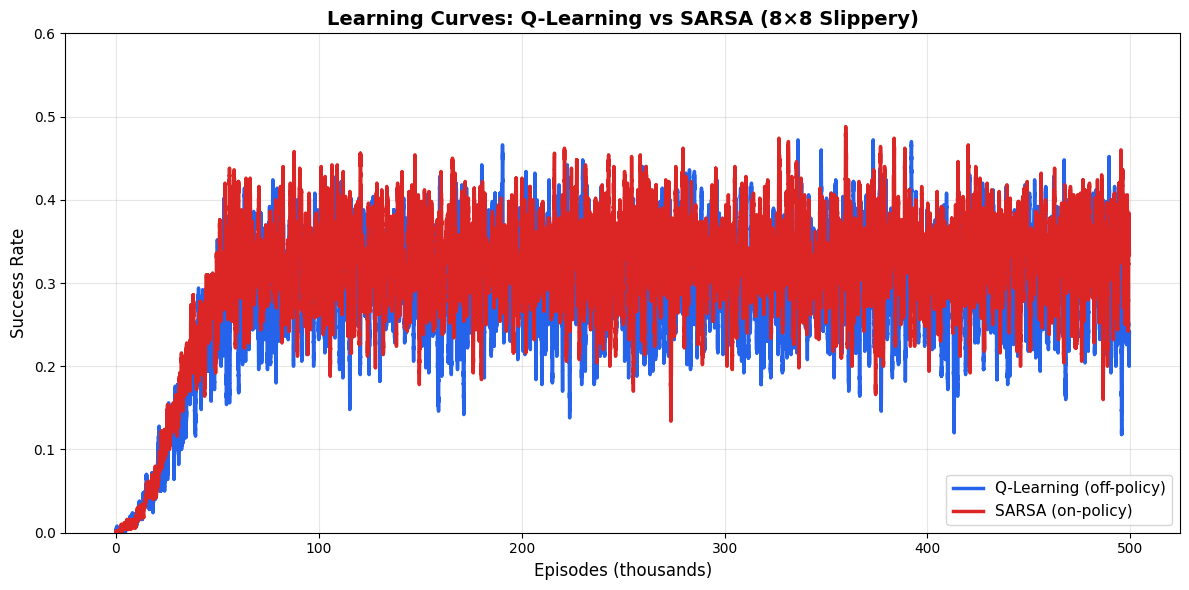

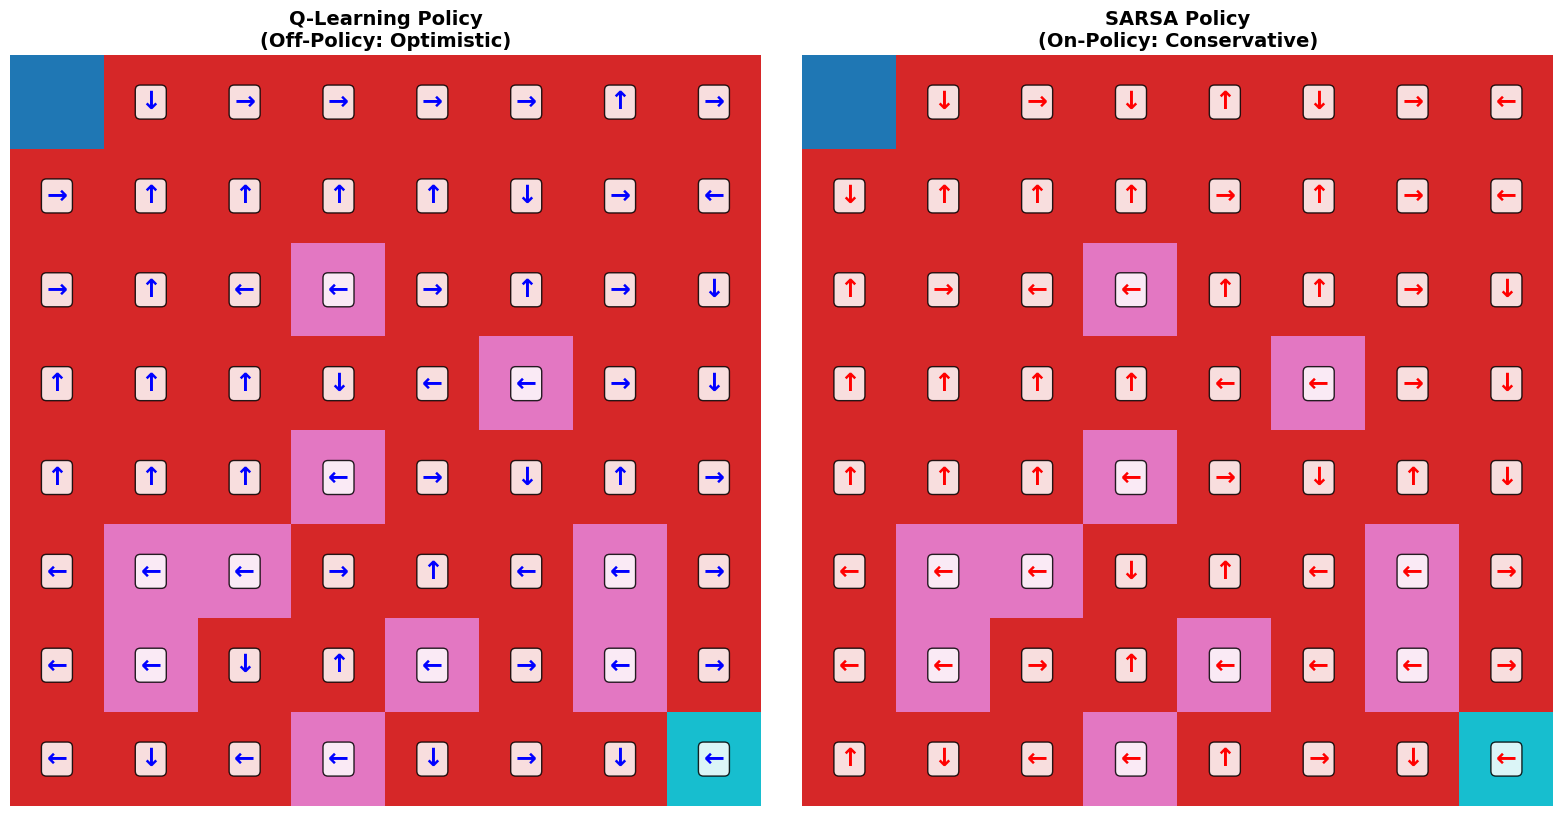

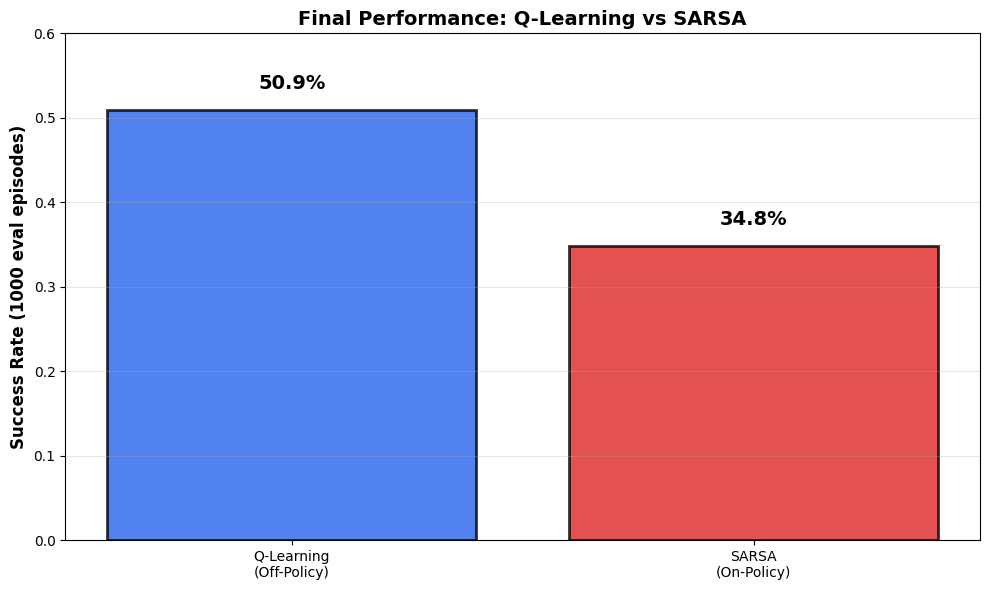


Q-Learning:
  Final 100 episodes: 31.0% ± 46.2%
  Final 1000 episodes: 26.6% ± 44.2%
  Peak success rate: 100.0%

SARSA:
  Final 100 episodes: 19.0% ± 39.2%
  Final 1000 episodes: 29.3% ± 45.5%
  Peak success rate: 100.0%

Policy divergence: 28.1% of states differ

Policy divergence: 28.1%
Training α=0.05...
  → Success: 41.0%
Training α=0.1...
  → Success: 29.3%
Training α=0.3...
  → Success: 15.8%


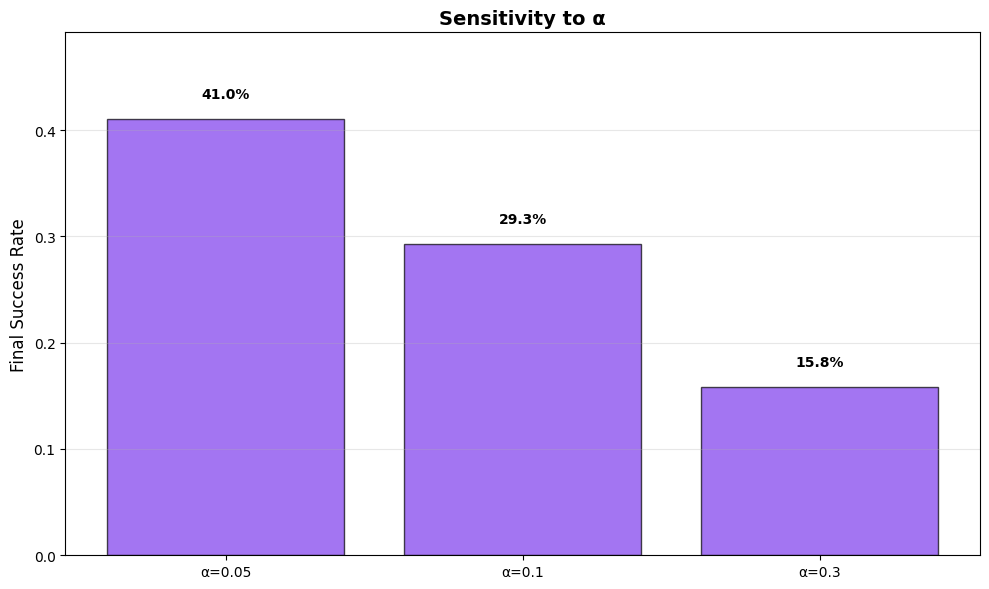

In [26]:
# After training
q_success, s_success = quick_test(Q_qlearn, Q_sarsa, env)
plot_learning_curves(success_qlearn, success_sarsa, save_path="learning_curves.png")
visualize_policies_fixed(Q_qlearn, Q_sarsa, env, save_path="policies.png")
plot_final_comparison(q_success, s_success, save_path="final_comparison.png")
summary_stats(success_qlearn, "Q-Learning")
summary_stats(success_sarsa, "SARSA")
print(f"\nPolicy divergence: {compare_policies(Q_qlearn, Q_sarsa):.1%}")

# For hyperparameter sweeps (lighter, optional)
alphas = [0.05, 0.1, 0.3]
alpha_results = run_alpha_sweep(alphas, env, num_episodes=100000)  # Fewer episodes for speed
plot_hyperparameter_sensitivity(alpha_results, "α")


In [ ]:
#this sums it up for the assignment 1. Even tho perplexity fixed some of my bugs... tomorrow i should go and redo the whole thing by hand, and make a pdf for it. And start with the 2nd assignment. 